In [1]:
import numpy as np
import pandas as pd
import random
import torch

Lets dynamically choose type of device to use for our computations. To run on your own GPU one needs to install pytorch and cuda-toolkit.

In [2]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

True


In [3]:
torch.cuda.get_device_properties(device)

/home/antoni_valls/CV/Kvasir-Semantic-Segmentation/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


_CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=10824MB, multi_processor_count=68)

Define the seed for reproductivity:

In [4]:
def set_seed(seed, use_gpu = True):
    """
    Set SEED for PyTorch reproducibility
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_gpu:
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 196
USE_SEED = True
if USE_SEED:
    set_seed(SEED, torch.cuda.is_available())

**Load the images and masks**

In [5]:
augmented = input("Data augmentation? (y/n)")

if augmented == "y":
    train_images = np.load("data/data/train_augmented/combined_images.npy")
    train_masks = np.load("data/data/train_augmented/combined_masks.npy")

elif augmented == "n":
    train_images = np.load("data/data/train_nonaugmented/train_images.npy")
    train_masks = np.load("data/data/train_nonaugmented/train_masks.npy")

else:
    raise ValueError(f"Only 'y' or 'n' ")

test_images = np.load("data/data/test/test_images.npy")
test_masks = np.load("data/data/test/test_masks.npy")

Data augmentation? (y/n) n


In [6]:
print("Train images shape:", train_images.shape)
print("Test images shape:", test_images.shape)
print("Train masks shape:", train_masks.shape)
print("Test masks shape:", test_masks.shape)

Train images shape: (700, 256, 256, 3)
Test images shape: (300, 256, 256, 3)
Train masks shape: (700, 256, 256, 1)
Test masks shape: (300, 256, 256, 1)


**Standaritzation**

In [7]:
mean = np.mean(train_images, axis = (0,1,2)) / 255
std = np.std(train_images, axis = (0,1,2)) / 255

print("-----  NORMALIZATION VALUES  -----")
print(f"Mean (RGB): {mean}")
print(f"Standard Deviation (RGB): {std}")

-----  NORMALIZATION VALUES  -----
Mean (RGB): [0.55863946 0.32152227 0.23399408]
Standard Deviation (RGB): [0.31859686 0.22169437 0.18710657]


In [8]:
import torchvision
import torchvision.transforms as transforms

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),  # Convert the image to a PyTorch tensor and normalize it between [0, 1]
    torchvision.transforms.Normalize(mean, std)  # Normalize the tensor using the provided mean and standard deviation
])

**Validation set**

In [9]:
from sklearn.model_selection import train_test_split

#Validation set (40%) of the testing images
testing_images, val_images, testing_masks, val_masks = train_test_split(
    test_images, test_masks, test_size=0.4, random_state=42)

# Check shape of training images and masks
print("Training Images Shape:", train_images.shape)
print("Training Masks Shape:", train_masks.shape)

# Check shape of validation images and masks
print("Validation Images Shape:", val_images.shape)
print("Validation Masks Shape:", val_masks.shape)

# Check length of training and validation sets
print("Number of Train Examples:", len(train_images))
print("Number of Validation Examples:", len(val_images))
print("Number of Test Examples:", len(testing_images))

Training Images Shape: (700, 256, 256, 3)
Training Masks Shape: (700, 256, 256, 1)
Validation Images Shape: (120, 256, 256, 3)
Validation Masks Shape: (120, 256, 256, 1)
Number of Train Examples: 700
Number of Validation Examples: 120
Number of Test Examples: 180


In [10]:
from src.preprocess import KvasirDataset

# Create KvasirDataset objects for train, validation and test sets
train_dataset = KvasirDataset(images=train_images, masks=train_masks, transforms=transforms)
val_dataset = KvasirDataset(images=val_images,masks=val_masks, transforms=transforms)
test_dataset = KvasirDataset(images=test_images, masks=test_masks, transforms=transforms) 


**Define the model**

In [11]:
config = {}
config['name']='Deeper_Att_DiceLoss_try_Non_Aug'
config['epochs']=100
config['batch_size']=8
config['arch']='AttU_Net'
config['deep_supervision']=False
config['input_channels']=3
config['num_classes']=1
config['early_stopping']=10 # 
#config['input_w']=128
#config['input_h']=128


In [12]:
from torch.utils.data import DataLoader

train_iterator = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
test_iterator = DataLoader(test_dataset, batch_size=config['batch_size'])
val_iterator = DataLoader(val_dataset,batch_size=config['batch_size'])

In [14]:
from src.main import AttU_Net
from src.utils import count_parameters

model = AttU_Net(config)
print(f"The model has {count_parameters(model):,} trainable parameters.")

The model has 8,726,077 trainable parameters.


In [14]:
model = model.to(device)

In [15]:
from src.loss import DiceLoss, IoULoss, BCEDiceLoss
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = DiceLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4) 
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=True)

/home/antoni_valls/CV/Kvasir-Semantic-Segmentation/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [16]:
from src.train_val_test import train, evaluate
from collections import OrderedDict

log = OrderedDict([
    ('epoch', []),
    ('loss', []),
    ('iou', []),
    ('dice',[]),
    ('accuracy',[]),
    ('val_loss', []),
    ('val_iou', []),
    ('val_dice',[]),
    ('val_accuracy',[])
])

best_dice = 0
trigger = 0
for epoch in range(config['epochs']):
    print('Epoch [%d/%d]' % (epoch, config['epochs']))

    # train for one epoch
    train_log = train(config, model, train_iterator, criterion, optimizer, config['deep_supervision'], device)
    # evaluate on validation set
    val_log = evaluate(config, model, val_iterator, criterion, config['deep_supervision'], device)

    print('loss %.4f - iou %.4f - dice %.4f - accuracy %.4f - val_loss %.4f - val_iou %.4f - val_dice %.4f - val_accuracy %.4f'
          % (train_log['loss'], train_log['iou'], train_log['dice_coef'], train_log['accuracy'],
             val_log['loss'], val_log['iou'], val_log['dice_coef'], val_log['accuracy']))

    log['epoch'].append(epoch)
    log['loss'].append(train_log['loss'])
    log['iou'].append(train_log['iou'])
    log['dice'].append(train_log['dice_coef'])
    log['accuracy'].append(train_log['accuracy'])
    log['val_loss'].append(val_log['loss'])
    log['val_iou'].append(val_log['iou'])
    log['val_dice'].append(val_log['dice_coef'])
    log['val_accuracy'].append(val_log['accuracy'])
    
    pd.DataFrame(log).to_csv('models/%s/log.csv' %
                             config['name'], index=False)

    trigger += 1

    if val_log['dice_coef'] > best_dice:
        torch.save(model.state_dict(), 'models/%s/model.pth' %
                   config['name'])
        best_dice = val_log['dice_coef']
        print("=> saved best model")
        trigger = 0

    # Reduce learning rate when validation metric stops improving
    scheduler.step(val_log['loss'])

    # early stopping
    if config['early_stopping'] >= 0 and trigger >= config['early_stopping']:
        print("=> early stopping")
        break

    torch.cuda.empty_cache()

Epoch [0/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 26.97it/s, loss=0.622, iou=0.235, dice_coef=0.378, accuracy=0.593]


loss 0.6334 - iou 0.2274 - dice 0.3666 - accuracy 0.6363 - val_loss 0.6224 - val_iou 0.2353 - val_dice 0.3776 - val_accuracy 0.5926
=> saved best model
Epoch [1/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 26.86it/s, loss=0.585, iou=0.265, dice_coef=0.415, accuracy=0.707]


loss 0.5856 - iou 0.2646 - dice 0.4144 - accuracy 0.6640 - val_loss 0.5846 - val_iou 0.2649 - val_dice 0.4154 - val_accuracy 0.7073
=> saved best model
Epoch [2/100]


100%|████████████████████████████| 15/15 [00:00<00:00, 26.91it/s, loss=0.578, iou=0.27, dice_coef=0.422, accuracy=0.705]


loss 0.5649 - iou 0.2808 - dice 0.4351 - accuracy 0.6883 - val_loss 0.5777 - val_iou 0.2704 - val_dice 0.4223 - val_accuracy 0.7054
=> saved best model
Epoch [3/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 26.91it/s, loss=0.594, iou=0.258, dice_coef=0.406, accuracy=0.594]


loss 0.5517 - iou 0.2926 - dice 0.4483 - accuracy 0.7035 - val_loss 0.5937 - val_iou 0.2577 - val_dice 0.4063 - val_accuracy 0.5941
Epoch [4/100]


100%|████████████████████████████| 15/15 [00:00<00:00, 26.96it/s, loss=0.566, iou=0.28, dice_coef=0.434, accuracy=0.683]


loss 0.5348 - iou 0.3074 - dice 0.4652 - accuracy 0.7230 - val_loss 0.5656 - val_iou 0.2799 - val_dice 0.4344 - val_accuracy 0.6834
=> saved best model
Epoch [5/100]


100%|████████████████████████████| 15/15 [00:00<00:00, 26.75it/s, loss=0.533, iou=0.307, dice_coef=0.467, accuracy=0.75]


loss 0.5162 - iou 0.3231 - dice 0.4838 - accuracy 0.7429 - val_loss 0.5329 - val_iou 0.3073 - val_dice 0.4671 - val_accuracy 0.7500
=> saved best model
Epoch [6/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 26.71it/s, loss=0.509, iou=0.328, dice_coef=0.491, accuracy=0.795]


loss 0.4938 - iou 0.3435 - dice 0.5062 - accuracy 0.7672 - val_loss 0.5091 - val_iou 0.3277 - val_dice 0.4909 - val_accuracy 0.7948
=> saved best model
Epoch [7/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 26.63it/s, loss=0.535, iou=0.307, dice_coef=0.465, accuracy=0.713]


loss 0.4751 - iou 0.3604 - dice 0.5249 - accuracy 0.7892 - val_loss 0.5347 - val_iou 0.3068 - val_dice 0.4653 - val_accuracy 0.7135
Epoch [8/100]


100%|████████████████████████████| 15/15 [00:00<00:00, 26.81it/s, loss=0.511, iou=0.327, dice_coef=0.489, accuracy=0.74]


loss 0.4590 - iou 0.3757 - dice 0.5410 - accuracy 0.8004 - val_loss 0.5106 - val_iou 0.3270 - val_dice 0.4894 - val_accuracy 0.7401
Epoch [9/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 26.67it/s, loss=0.466, iou=0.368, dice_coef=0.534, accuracy=0.809]


loss 0.4374 - iou 0.3965 - dice 0.5626 - accuracy 0.8226 - val_loss 0.4655 - val_iou 0.3682 - val_dice 0.5345 - val_accuracy 0.8091
=> saved best model
Epoch [10/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 26.70it/s, loss=0.447, iou=0.385, dice_coef=0.553, accuracy=0.838]


loss 0.4073 - iou 0.4256 - dice 0.5927 - accuracy 0.8451 - val_loss 0.4472 - val_iou 0.3846 - val_dice 0.5528 - val_accuracy 0.8379
=> saved best model
Epoch [11/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 26.65it/s, loss=0.437, iou=0.395, dice_coef=0.563, accuracy=0.835]


loss 0.3933 - iou 0.4419 - dice 0.6067 - accuracy 0.8568 - val_loss 0.4368 - val_iou 0.3951 - val_dice 0.5632 - val_accuracy 0.8347
=> saved best model
Epoch [12/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 26.52it/s, loss=0.419, iou=0.414, dice_coef=0.581, accuracy=0.888]


loss 0.3731 - iou 0.4610 - dice 0.6269 - accuracy 0.8690 - val_loss 0.4192 - val_iou 0.4137 - val_dice 0.5808 - val_accuracy 0.8877
=> saved best model
Epoch [13/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 26.25it/s, loss=0.419, iou=0.412, dice_coef=0.581, accuracy=0.872]


loss 0.3505 - iou 0.4853 - dice 0.6495 - accuracy 0.9043 - val_loss 0.4189 - val_iou 0.4124 - val_dice 0.5811 - val_accuracy 0.8719
=> saved best model
Epoch [14/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 26.16it/s, loss=0.403, iou=0.429, dice_coef=0.597, accuracy=0.891]


loss 0.3360 - iou 0.5023 - dice 0.6640 - accuracy 0.9143 - val_loss 0.4033 - val_iou 0.4292 - val_dice 0.5967 - val_accuracy 0.8906
=> saved best model
Epoch [15/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 25.90it/s, loss=0.398, iou=0.435, dice_coef=0.602, accuracy=0.879]


loss 0.3091 - iou 0.5341 - dice 0.6909 - accuracy 0.9247 - val_loss 0.3975 - val_iou 0.4346 - val_dice 0.6025 - val_accuracy 0.8787
=> saved best model
Epoch [16/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 26.06it/s, loss=0.349, iou=0.486, dice_coef=0.651, accuracy=0.908]


loss 0.2843 - iou 0.5632 - dice 0.7157 - accuracy 0.9310 - val_loss 0.3488 - val_iou 0.4858 - val_dice 0.6512 - val_accuracy 0.9078
=> saved best model
Epoch [17/100]


100%|█████████████████████████████| 15/15 [00:00<00:00, 25.52it/s, loss=0.35, iou=0.487, dice_coef=0.65, accuracy=0.907]


loss 0.2713 - iou 0.5805 - dice 0.7287 - accuracy 0.9333 - val_loss 0.3501 - val_iou 0.4875 - val_dice 0.6499 - val_accuracy 0.9074
Epoch [18/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 25.36it/s, loss=0.332, iou=0.507, dice_coef=0.668, accuracy=0.912]


loss 0.2490 - iou 0.6069 - dice 0.7510 - accuracy 0.9364 - val_loss 0.3319 - val_iou 0.5067 - val_dice 0.6681 - val_accuracy 0.9123
=> saved best model
Epoch [19/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 25.29it/s, loss=0.344, iou=0.494, dice_coef=0.656, accuracy=0.894]


loss 0.2414 - iou 0.6179 - dice 0.7586 - accuracy 0.9369 - val_loss 0.3436 - val_iou 0.4944 - val_dice 0.6564 - val_accuracy 0.8939
Epoch [20/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 25.05it/s, loss=0.332, iou=0.508, dice_coef=0.668, accuracy=0.914]


loss 0.2132 - iou 0.6538 - dice 0.7868 - accuracy 0.9434 - val_loss 0.3321 - val_iou 0.5080 - val_dice 0.6679 - val_accuracy 0.9138
Epoch [21/100]


100%|█████████████████████████████| 15/15 [00:00<00:00, 25.04it/s, loss=0.34, iou=0.504, dice_coef=0.66, accuracy=0.915]


loss 0.1851 - iou 0.6918 - dice 0.8149 - accuracy 0.9498 - val_loss 0.3398 - val_iou 0.5041 - val_dice 0.6602 - val_accuracy 0.9149
Epoch [22/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 24.38it/s, loss=0.366, iou=0.474, dice_coef=0.634, accuracy=0.908]


loss 0.1850 - iou 0.6922 - dice 0.8150 - accuracy 0.9468 - val_loss 0.3659 - val_iou 0.4737 - val_dice 0.6341 - val_accuracy 0.9085
Epoch [23/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 24.58it/s, loss=0.306, iou=0.537, dice_coef=0.694, accuracy=0.904]


loss 0.1601 - iou 0.7278 - dice 0.8399 - accuracy 0.9529 - val_loss 0.3060 - val_iou 0.5366 - val_dice 0.6940 - val_accuracy 0.9036
=> saved best model
Epoch [24/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 24.51it/s, loss=0.291, iou=0.554, dice_coef=0.709, accuracy=0.914]


loss 0.1650 - iou 0.7202 - dice 0.8350 - accuracy 0.9494 - val_loss 0.2908 - val_iou 0.5542 - val_dice 0.7092 - val_accuracy 0.9143
=> saved best model
Epoch [25/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 24.77it/s, loss=0.319, iou=0.524, dice_coef=0.681, accuracy=0.913]


loss 0.1468 - iou 0.7484 - dice 0.8532 - accuracy 0.9545 - val_loss 0.3189 - val_iou 0.5244 - val_dice 0.6811 - val_accuracy 0.9131
Epoch [26/100]


100%|█████████████████████████████| 15/15 [00:00<00:00, 24.20it/s, loss=0.32, iou=0.526, dice_coef=0.68, accuracy=0.914]


loss 0.1491 - iou 0.7436 - dice 0.8509 - accuracy 0.9520 - val_loss 0.3203 - val_iou 0.5256 - val_dice 0.6797 - val_accuracy 0.9137
Epoch [27/100]


100%|█████████████████████████████| 15/15 [00:00<00:00, 24.35it/s, loss=0.338, iou=0.5, dice_coef=0.662, accuracy=0.871]


loss 0.1324 - iou 0.7690 - dice 0.8676 - accuracy 0.9561 - val_loss 0.3380 - val_iou 0.4995 - val_dice 0.6620 - val_accuracy 0.8705
Epoch [28/100]


100%|█████████████████████████████| 15/15 [00:00<00:00, 24.14it/s, loss=0.26, iou=0.591, dice_coef=0.74, accuracy=0.916]


loss 0.1253 - iou 0.7802 - dice 0.8747 - accuracy 0.9576 - val_loss 0.2602 - val_iou 0.5913 - val_dice 0.7398 - val_accuracy 0.9161
=> saved best model
Epoch [29/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 24.07it/s, loss=0.274, iou=0.575, dice_coef=0.726, accuracy=0.908]


loss 0.1071 - iou 0.8079 - dice 0.8929 - accuracy 0.9619 - val_loss 0.2744 - val_iou 0.5748 - val_dice 0.7256 - val_accuracy 0.9082
Epoch [30/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 24.10it/s, loss=0.271, iou=0.581, dice_coef=0.729, accuracy=0.917]


loss 0.1009 - iou 0.8181 - dice 0.8991 - accuracy 0.9634 - val_loss 0.2706 - val_iou 0.5813 - val_dice 0.7294 - val_accuracy 0.9172
Epoch [31/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 24.00it/s, loss=0.258, iou=0.598, dice_coef=0.742, accuracy=0.917]


loss 0.1064 - iou 0.8109 - dice 0.8936 - accuracy 0.9614 - val_loss 0.2584 - val_iou 0.5976 - val_dice 0.7416 - val_accuracy 0.9166
=> saved best model
Epoch [32/100]


100%|████████████████████████████| 15/15 [00:00<00:00, 24.01it/s, loss=0.247, iou=0.613, dice_coef=0.753, accuracy=0.92]


loss 0.0876 - iou 0.8402 - dice 0.9124 - accuracy 0.9665 - val_loss 0.2467 - val_iou 0.6131 - val_dice 0.7533 - val_accuracy 0.9201
=> saved best model
Epoch [33/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 23.90it/s, loss=0.317, iou=0.529, dice_coef=0.683, accuracy=0.912]


loss 0.0943 - iou 0.8303 - dice 0.9057 - accuracy 0.9641 - val_loss 0.3175 - val_iou 0.5295 - val_dice 0.6825 - val_accuracy 0.9122
Epoch [34/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 23.96it/s, loss=0.271, iou=0.583, dice_coef=0.729, accuracy=0.922]


loss 0.0813 - iou 0.8507 - dice 0.9187 - accuracy 0.9670 - val_loss 0.2709 - val_iou 0.5832 - val_dice 0.7291 - val_accuracy 0.9217
Epoch [35/100]


100%|████████████████████████████| 15/15 [00:00<00:00, 23.94it/s, loss=0.251, iou=0.61, dice_coef=0.749, accuracy=0.921]


loss 0.0762 - iou 0.8598 - dice 0.9238 - accuracy 0.9685 - val_loss 0.2509 - val_iou 0.6097 - val_dice 0.7491 - val_accuracy 0.9210
Epoch [36/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 23.83it/s, loss=0.252, iou=0.604, dice_coef=0.748, accuracy=0.911]


loss 0.0856 - iou 0.8436 - dice 0.9144 - accuracy 0.9648 - val_loss 0.2520 - val_iou 0.6041 - val_dice 0.7480 - val_accuracy 0.9114
Epoch [37/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 23.77it/s, loss=0.239, iou=0.624, dice_coef=0.761, accuracy=0.926]


loss 0.0714 - iou 0.8674 - dice 0.9286 - accuracy 0.9683 - val_loss 0.2392 - val_iou 0.6238 - val_dice 0.7608 - val_accuracy 0.9256
=> saved best model
Epoch [38/100]


100%|█████████████████████████████| 15/15 [00:00<00:00, 23.43it/s, loss=0.25, iou=0.612, dice_coef=0.75, accuracy=0.923]


loss 0.0676 - iou 0.8742 - dice 0.9324 - accuracy 0.9694 - val_loss 0.2496 - val_iou 0.6115 - val_dice 0.7504 - val_accuracy 0.9232
Epoch [39/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 23.49it/s, loss=0.249, iou=0.611, dice_coef=0.751, accuracy=0.925]


loss 0.0602 - iou 0.8871 - dice 0.9398 - accuracy 0.9710 - val_loss 0.2494 - val_iou 0.6110 - val_dice 0.7506 - val_accuracy 0.9247
Epoch [40/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 23.71it/s, loss=0.246, iou=0.611, dice_coef=0.754, accuracy=0.915]


loss 0.0585 - iou 0.8903 - dice 0.9415 - accuracy 0.9715 - val_loss 0.2462 - val_iou 0.6110 - val_dice 0.7538 - val_accuracy 0.9147
Epoch [41/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 23.28it/s, loss=0.227, iou=0.638, dice_coef=0.773, accuracy=0.927]


loss 0.0531 - iou 0.8997 - dice 0.9469 - accuracy 0.9727 - val_loss 0.2271 - val_iou 0.6376 - val_dice 0.7729 - val_accuracy 0.9271
=> saved best model
Epoch [42/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 23.46it/s, loss=0.284, iou=0.563, dice_coef=0.716, accuracy=0.892]


loss 0.0743 - iou 0.8643 - dice 0.9257 - accuracy 0.9663 - val_loss 0.2841 - val_iou 0.5633 - val_dice 0.7159 - val_accuracy 0.8925
Epoch [43/100]


100%|████████████████████████████| 15/15 [00:00<00:00, 23.38it/s, loss=0.283, iou=0.562, dice_coef=0.717, accuracy=0.89]


loss 0.1011 - iou 0.8193 - dice 0.8989 - accuracy 0.9575 - val_loss 0.2834 - val_iou 0.5621 - val_dice 0.7166 - val_accuracy 0.8899
Epoch [44/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 23.49it/s, loss=0.227, iou=0.636, dice_coef=0.773, accuracy=0.919]


loss 0.0646 - iou 0.8796 - dice 0.9354 - accuracy 0.9685 - val_loss 0.2274 - val_iou 0.6359 - val_dice 0.7726 - val_accuracy 0.9192
Epoch [45/100]


100%|█████████████████████████████| 15/15 [00:00<00:00, 23.29it/s, loss=0.28, iou=0.575, dice_coef=0.72, accuracy=0.918]


loss 0.0561 - iou 0.8944 - dice 0.9439 - accuracy 0.9709 - val_loss 0.2802 - val_iou 0.5749 - val_dice 0.7198 - val_accuracy 0.9178
Epoch [46/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 23.34it/s, loss=0.221, iou=0.646, dice_coef=0.779, accuracy=0.926]


loss 0.0524 - iou 0.9012 - dice 0.9476 - accuracy 0.9719 - val_loss 0.2211 - val_iou 0.6461 - val_dice 0.7789 - val_accuracy 0.9264
=> saved best model
Epoch [47/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 23.59it/s, loss=0.233, iou=0.631, dice_coef=0.767, accuracy=0.926]


loss 0.0458 - iou 0.9128 - dice 0.9542 - accuracy 0.9733 - val_loss 0.2330 - val_iou 0.6315 - val_dice 0.7670 - val_accuracy 0.9256
Epoch [48/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 23.48it/s, loss=0.231, iou=0.636, dice_coef=0.769, accuracy=0.927]


loss 0.0421 - iou 0.9196 - dice 0.9579 - accuracy 0.9741 - val_loss 0.2307 - val_iou 0.6359 - val_dice 0.7693 - val_accuracy 0.9268
Epoch [49/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 23.47it/s, loss=0.224, iou=0.642, dice_coef=0.776, accuracy=0.928]


loss 0.0413 - iou 0.9212 - dice 0.9587 - accuracy 0.9746 - val_loss 0.2245 - val_iou 0.6419 - val_dice 0.7755 - val_accuracy 0.9277
Epoch [50/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 23.36it/s, loss=0.214, iou=0.655, dice_coef=0.786, accuracy=0.927]


loss 0.0393 - iou 0.9246 - dice 0.9607 - accuracy 0.9747 - val_loss 0.2142 - val_iou 0.6546 - val_dice 0.7858 - val_accuracy 0.9272
=> saved best model
Epoch [51/100]


100%|█████████████████████████████| 15/15 [00:00<00:00, 22.99it/s, loss=0.25, iou=0.613, dice_coef=0.75, accuracy=0.924]


loss 0.0396 - iou 0.9240 - dice 0.9604 - accuracy 0.9743 - val_loss 0.2499 - val_iou 0.6130 - val_dice 0.7501 - val_accuracy 0.9239
Epoch [52/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 23.30it/s, loss=0.229, iou=0.641, dice_coef=0.771, accuracy=0.927]


loss 0.0363 - iou 0.9302 - dice 0.9637 - accuracy 0.9751 - val_loss 0.2286 - val_iou 0.6406 - val_dice 0.7714 - val_accuracy 0.9275
Epoch [53/100]


100%|████████████████████████████| 15/15 [00:00<00:00, 23.20it/s, loss=0.228, iou=0.64, dice_coef=0.772, accuracy=0.928]


loss 0.0363 - iou 0.9304 - dice 0.9637 - accuracy 0.9751 - val_loss 0.2282 - val_iou 0.6399 - val_dice 0.7718 - val_accuracy 0.9283
Epoch [54/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 22.55it/s, loss=0.223, iou=0.643, dice_coef=0.777, accuracy=0.921]


loss 0.0369 - iou 0.9292 - dice 0.9631 - accuracy 0.9749 - val_loss 0.2227 - val_iou 0.6426 - val_dice 0.7773 - val_accuracy 0.9213
Epoch [55/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 23.37it/s, loss=0.219, iou=0.651, dice_coef=0.781, accuracy=0.929]


loss 0.0351 - iou 0.9323 - dice 0.9649 - accuracy 0.9752 - val_loss 0.2193 - val_iou 0.6511 - val_dice 0.7807 - val_accuracy 0.9292
Epoch [56/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 22.81it/s, loss=0.213, iou=0.656, dice_coef=0.787, accuracy=0.926]


loss 0.0333 - iou 0.9357 - dice 0.9667 - accuracy 0.9756 - val_loss 0.2130 - val_iou 0.6559 - val_dice 0.7870 - val_accuracy 0.9261
=> saved best model
Epoch [57/100]


100%|█████████████████████████████| 15/15 [00:00<00:00, 22.90it/s, loss=0.23, iou=0.635, dice_coef=0.77, accuracy=0.922]


loss 0.0376 - iou 0.9279 - dice 0.9624 - accuracy 0.9742 - val_loss 0.2296 - val_iou 0.6353 - val_dice 0.7704 - val_accuracy 0.9221
Epoch [58/100]


100%|█████████████████████████████| 15/15 [00:00<00:00, 22.88it/s, loss=0.25, iou=0.614, dice_coef=0.75, accuracy=0.922]


loss 0.0468 - iou 0.9112 - dice 0.9532 - accuracy 0.9715 - val_loss 0.2498 - val_iou 0.6138 - val_dice 0.7502 - val_accuracy 0.9221
Epoch [59/100]


100%|█████████████████████████████| 15/15 [00:00<00:00, 22.77it/s, loss=0.24, iou=0.623, dice_coef=0.76, accuracy=0.918]


loss 0.0455 - iou 0.9133 - dice 0.9545 - accuracy 0.9717 - val_loss 0.2402 - val_iou 0.6231 - val_dice 0.7598 - val_accuracy 0.9176
Epoch [60/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 22.95it/s, loss=0.292, iou=0.556, dice_coef=0.708, accuracy=0.888]


loss 0.0695 - iou 0.8712 - dice 0.9305 - accuracy 0.9649 - val_loss 0.2916 - val_iou 0.5556 - val_dice 0.7084 - val_accuracy 0.8879
Epoch [61/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 23.31it/s, loss=0.254, iou=0.604, dice_coef=0.746, accuracy=0.919]


loss 0.0557 - iou 0.8953 - dice 0.9443 - accuracy 0.9687 - val_loss 0.2538 - val_iou 0.6036 - val_dice 0.7462 - val_accuracy 0.9192
Epoch [62/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 21.93it/s, loss=0.209, iou=0.662, dice_coef=0.791, accuracy=0.926]


loss 0.0439 - iou 0.9163 - dice 0.9561 - accuracy 0.9724 - val_loss 0.2087 - val_iou 0.6621 - val_dice 0.7913 - val_accuracy 0.9265
=> saved best model
Epoch [63/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 23.31it/s, loss=0.241, iou=0.624, dice_coef=0.759, accuracy=0.926]


loss 0.0352 - iou 0.9322 - dice 0.9648 - accuracy 0.9748 - val_loss 0.2407 - val_iou 0.6242 - val_dice 0.7593 - val_accuracy 0.9258
Epoch [64/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 23.05it/s, loss=0.218, iou=0.649, dice_coef=0.782, accuracy=0.928]


loss 0.0314 - iou 0.9393 - dice 0.9686 - accuracy 0.9756 - val_loss 0.2185 - val_iou 0.6492 - val_dice 0.7815 - val_accuracy 0.9277
Epoch [65/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 22.90it/s, loss=0.226, iou=0.641, dice_coef=0.774, accuracy=0.927]


loss 0.0289 - iou 0.9439 - dice 0.9711 - accuracy 0.9761 - val_loss 0.2263 - val_iou 0.6407 - val_dice 0.7737 - val_accuracy 0.9269
Epoch [66/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 22.55it/s, loss=0.231, iou=0.636, dice_coef=0.769, accuracy=0.926]


loss 0.0281 - iou 0.9455 - dice 0.9719 - accuracy 0.9762 - val_loss 0.2315 - val_iou 0.6361 - val_dice 0.7685 - val_accuracy 0.9258
Epoch [67/100]


100%|█████████████████████████████| 15/15 [00:00<00:00, 22.47it/s, loss=0.23, iou=0.637, dice_coef=0.77, accuracy=0.927]


loss 0.0286 - iou 0.9445 - dice 0.9714 - accuracy 0.9761 - val_loss 0.2295 - val_iou 0.6374 - val_dice 0.7705 - val_accuracy 0.9272
Epoch [68/100]


100%|█████████████████████████████| 15/15 [00:00<00:00, 23.26it/s, loss=0.23, iou=0.636, dice_coef=0.77, accuracy=0.926]


loss 0.0274 - iou 0.9468 - dice 0.9726 - accuracy 0.9763 - val_loss 0.2299 - val_iou 0.6357 - val_dice 0.7701 - val_accuracy 0.9262
Epoch [69/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 23.11it/s, loss=0.217, iou=0.652, dice_coef=0.783, accuracy=0.928]


loss 0.0258 - iou 0.9499 - dice 0.9742 - accuracy 0.9767 - val_loss 0.2171 - val_iou 0.6520 - val_dice 0.7829 - val_accuracy 0.9284
Epoch [70/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 22.64it/s, loss=0.223, iou=0.645, dice_coef=0.777, accuracy=0.928]


loss 0.0251 - iou 0.9513 - dice 0.9749 - accuracy 0.9768 - val_loss 0.2230 - val_iou 0.6451 - val_dice 0.7770 - val_accuracy 0.9277
Epoch [71/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 22.61it/s, loss=0.227, iou=0.641, dice_coef=0.773, accuracy=0.927]


loss 0.0241 - iou 0.9529 - dice 0.9759 - accuracy 0.9769 - val_loss 0.2267 - val_iou 0.6405 - val_dice 0.7733 - val_accuracy 0.9274
Epoch [72/100]


100%|███████████████████████████| 15/15 [00:00<00:00, 22.64it/s, loss=0.229, iou=0.638, dice_coef=0.771, accuracy=0.927]

loss 0.0245 - iou 0.9523 - dice 0.9755 - accuracy 0.9769 - val_loss 0.2285 - val_iou 0.6385 - val_dice 0.7715 - val_accuracy 0.9271
=> early stopping


In [17]:
test_log = evaluate(config, model, test_iterator, criterion, config['deep_supervision'], device)

pd.DataFrame([test_log]).to_csv('models/%s/test_log.csv' % config['name'])

print('test_loss %.4f - test_iou %.4f - test_dice %.4f - test_accuracy %.4f'
          % (test_log['loss'], test_log['iou'], test_log['dice_coef'], test_log['accuracy']))

100%|████████████████████████████| 38/38 [00:01<00:00, 22.85it/s, loss=0.215, iou=0.653, dice_coef=0.785, accuracy=0.93]

test_loss 0.2147 - test_iou 0.6527 - test_dice 0.7853 - test_accuracy 0.9302


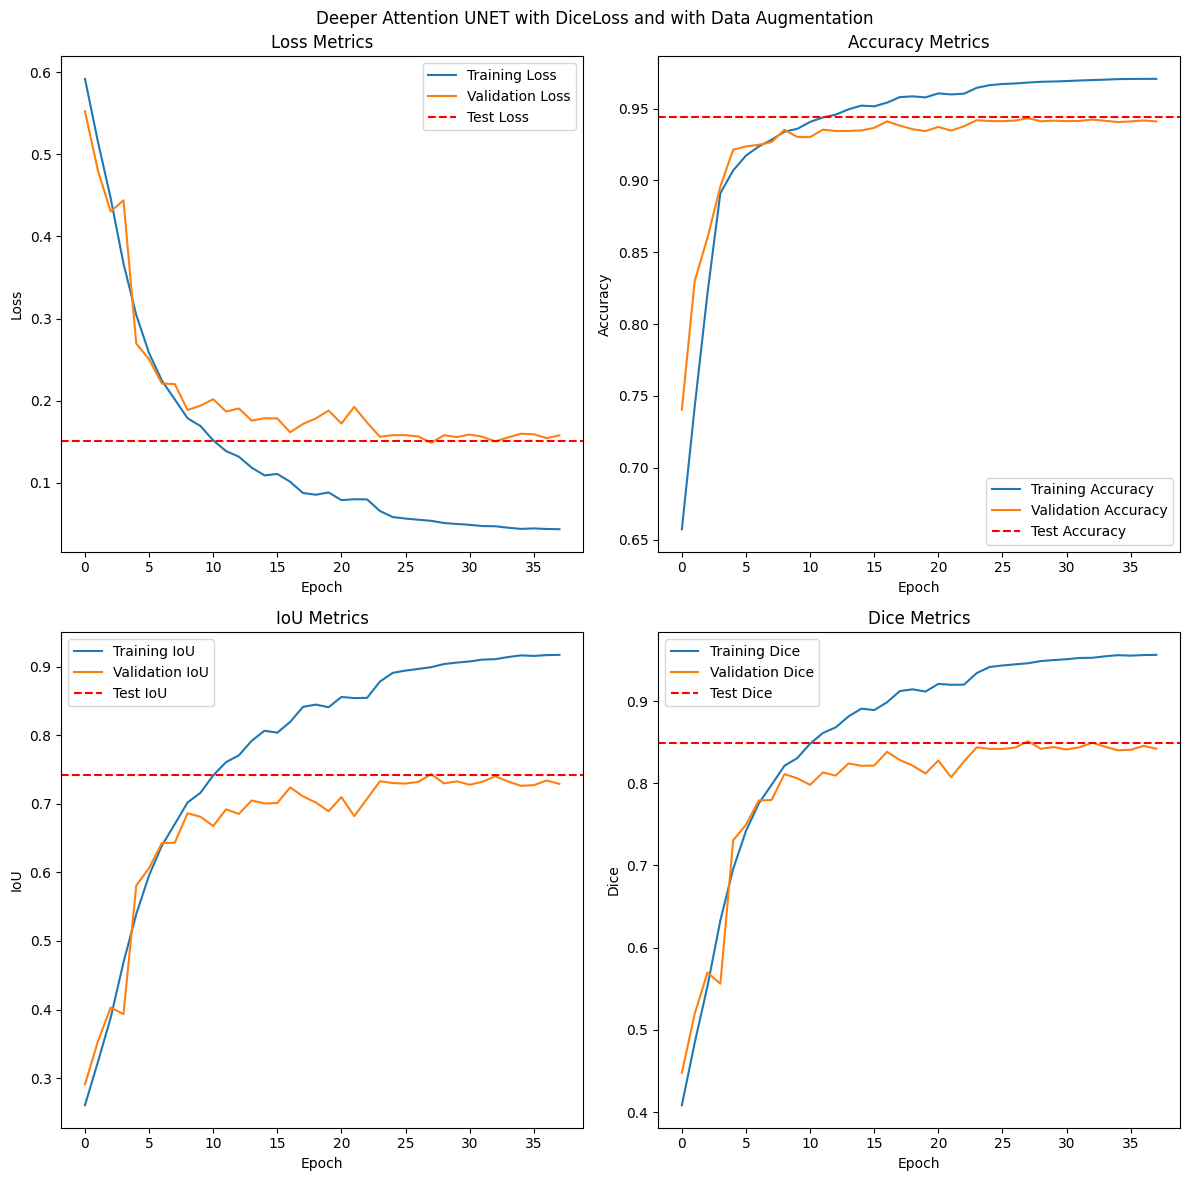

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('models/Deeper_Att_DiceLoss_try_Aug/log.csv')
test = pd.read_csv('models/Deeper_Att_DiceLoss_try_Aug/test_log.csv')

# Test values for loss, IoU, and Dice coefficients
test_loss = test['loss'].item()  
test_iou = test['iou'].item() 
test_dice = test['dice_coef'].item() 
test_accuracy = test['accuracy'].item() 

# Create a figure and subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

# Plot the loss features in the first subplot
ax1.plot(df['epoch'], df['loss'], label='Training Loss')
ax1.plot(df['epoch'], df['val_loss'], label='Validation Loss')
ax1.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
ax1.annotate(f'{test_loss:.2f}', xy=(90, test_loss+0.005), color='r')
ax1.set_title('Loss Metrics')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(df['epoch'], df['accuracy'], label='Training Accuracy')
ax2.plot(df['epoch'], df['val_accuracy'], label='Validation Accuracy')
ax2.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
ax2.annotate(f'{test_accuracy:.2f}', xy=(90, test_accuracy+0.002), color='r')
ax2.set_title('Accuracy Metrics')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

ax3.plot(df['epoch'], df['iou'], label='Training IoU')
ax3.plot(df['epoch'], df['val_iou'], label='Validation IoU')
ax3.axhline(y=test_iou, color='r', linestyle='--', label='Test IoU')
ax3.annotate(f'{test_iou:.2f}', xy=(90, test_iou+0.003), color='r')
ax3.set_title('IoU Metrics')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('IoU')
ax3.legend()

ax4.plot(df['epoch'], df['dice'], label='Training Dice')
ax4.plot(df['epoch'], df['val_dice'], label='Validation Dice')
ax4.axhline(y=test_dice, color='r', linestyle='--', label='Test Dice')
ax4.annotate(f'{test_dice:.2f}', xy=(90, test_dice+0.005), color='r')
ax4.set_title('Dice Metrics')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Dice')
ax4.legend()

fig.suptitle("Deeper Attention UNET with DiceLoss and with Data Augmentation")
# Adjust the spacing between subplots
plt.tight_layout()

plt.savefig("results/Deeper_Att_DiceLoss_Aug.png")
# Display the plot
plt.show()